# Hyperparameter Tuning

In [1]:
import joblib

# Import models
lgbm_model = joblib.load("../models/lgbm_base_model.joblib")
catboost_model = joblib.load("../models/catboost_base_model.joblib")

In [2]:
import pandas as pd

train_df = pd.read_csv("../datasets/UNSW_NB15_preprocessed_training-set.csv")
test_df = pd.read_csv("../datasets/UNSW_NB15_preprocessed_testing-set.csv")

**Prepare Data**

In [3]:
# Split train set
X_train = train_df.drop(columns=["id", "attack_cat", "label"])
y_train = train_df["label"]

# Split test set
X_test = test_df.drop(columns=["id", "attack_cat", "label"])
y_test = test_df["label"]

## LightGBM

In [6]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

lgbm_param_dist = {
    "num_leaves": np.arange(20, 150, 10),
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [100, 500, 1000, 1500],
    "max_depth": np.arange(3, 15, 2),
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "device": ["gpu"]
}

lgbm_random_search = RandomizedSearchCV(
    lgbm_model,  
    param_distributions=lgbm_param_dist,
    n_iter=30,
    cv=5,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

lgbm_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
13 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\lightgbm\sklearn.py", line 1284, in fit
    super().fit(
  File "C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\lightgbm\sklearn.py", line 955, in fit
    self._Booster = train(


[LightGBM] [Info] Number of positive: 119341, number of negative: 56000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6932
[LightGBM] [Info] Number of data points in the train set: 175341, number of used features: 58
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 39 dense feature groups (6.69 MB) transferred to GPU in 0.008132 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.680622 -> initscore=0.756633
[LightGBM] [Info] Start training from score 0.756633


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(device='gpu'), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'device': ['gpu'],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': array([ 3,  5,  7,  9, 11, 13]),
                                        'n_estimators': [100, 500, 1000, 1500],
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140]),
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [7]:
print("Best Parameters:", lgbm_random_search.best_params_)
print("Best Score:", lgbm_random_search.best_score_)

Best Parameters: {'subsample': 0.8, 'num_leaves': 20, 'n_estimators': 1500, 'max_depth': 13, 'learning_rate': 0.05, 'device': 'gpu', 'colsample_bytree': 0.8}
Best Score: 0.9149199591765713


In [8]:
lgbm_random_search.score(X_test, y_test)

0.8727469270757421

In [4]:
# Import our custom function from ./src/utils/print_unique_values.py
import sys
import os
from pathlib import Path

# Get the current notebook's directory
notebook_dir = Path.cwd()

# Add the src directory to the sys.path
sys.path.append(str(notebook_dir.parent))  # Go up one level from notebooks

# Import the function
from utils.evaluate_classification import evaluate_classification
from utils.plot_auc_roc import plot_auc_roc
from utils.plot_confusion_matrix import plot_confusion_matrix

In [10]:
# Predict labels and probabilities
y_pred = lgbm_random_search.predict(X_test)
y_proba = lgbm_random_search.predict_proba(X_test)[:, 1]

In [11]:
# Get evaluation metrics
lgbm_metrics = evaluate_classification(y_test, y_pred, "LightGBM")
print("Evaluation Metrics:")
lgbm_metrics

Evaluation Metrics:


{'Model Name': 'LightGBM',
 'Accuracy': 0.8727469270757421,
 'Precision': 0.8210371189094593,
 'Recall': 0.9831906820788847,
 'F1 Score': 0.89482718813054}

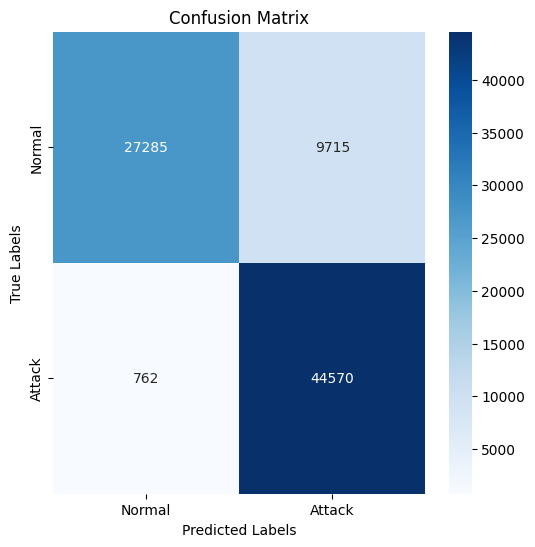

In [12]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names=["Normal", "Attack"])

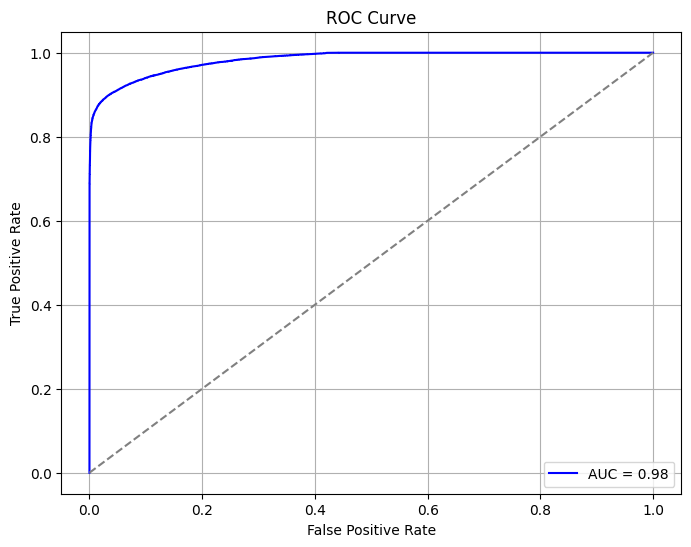

AUC: 0.9833


In [13]:
# Plot AUC-ROC
lgbm_auc = plot_auc_roc(y_test, y_proba)
print(f"AUC: {lgbm_auc:.4f}")

In [14]:
# Save the tuned LightGBM model
joblib.dump(lgbm_random_search, "../models/lgbm_rs_model.joblib")

['../models/lgbm_rs_model.joblib']

**GridSearchCV**

In [12]:
lgbm_param_grid = {
    "num_leaves": [10, 20, 30],  # Narrow around 20
    "learning_rate": [0.05, 0.1, 0.15],  # Narrow around 0.1
    "n_estimators": [1300, 1500, 1700],  # Narrow around 1500
    "max_depth": [2, 3, 4],  # Narrow around 3
    "subsample": [0.7, 0.8, 0.9],  # Narrow around 0.8
    "colsample_bytree": [0.7, 0.8, 0.9]  # Narrow around 0.8
}

# Initialize GridSearchCV
lgbm_grid_search = GridSearchCV(
    estimator=lgbm_model,  # Your LightGBM model
    param_grid=lgbm_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
lgbm_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
310 fits failed out of a total of 3645.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_

[LightGBM] [Info] Number of positive: 119341, number of negative: 56000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6932
[LightGBM] [Info] Number of data points in the train set: 175341, number of used features: 58
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 39 dense feature groups (6.69 MB) transferred to GPU in 0.017615 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.680622 -> initscore=0.756633
[LightGBM] [Info] Start training from score 0.756633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

GridSearchCV(cv=5, estimator=LGBMClassifier(device='gpu'), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [1300, 1500, 1700],
                         'num_leaves': [10, 20, 30],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=2)

In [13]:
# Print the best parameters and best score
print("Best GridSearchCV Parameters:", lgbm_grid_search.best_params_)
print("Best GridSearchCV Score:", lgbm_grid_search.best_score_)

Best GridSearchCV Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 1300, 'num_leaves': 10, 'subsample': 0.8}
Best GridSearchCV Score: 0.9162202914261259


In [14]:
lgbm_grid_search.score(X_test, y_test)

0.8676456298887432

In [15]:
# Predict labels and probabilities
y_pred = lgbm_random_search.predict(X_test)
y_proba = lgbm_random_search.predict_proba(X_test)[:, 1]

In [16]:
# Get evaluation metrics
lgbm_metrics = evaluate_classification(y_test, y_pred, "LightGBM")
print("Evaluation Metrics:")
lgbm_metrics

Evaluation Metrics:


{'Model Name': 'LightGBM',
 'Accuracy': 0.8735607054365253,
 'Precision': 0.8231005514229673,
 'Recall': 0.9812494485131915,
 'F1 Score': 0.8952442288727434}

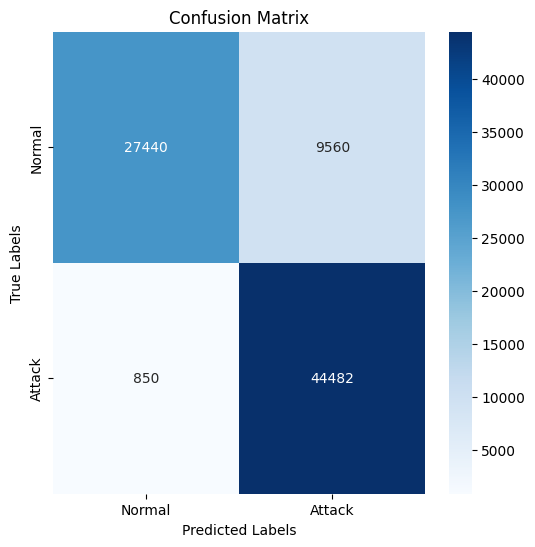

In [17]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names=["Normal", "Attack"])

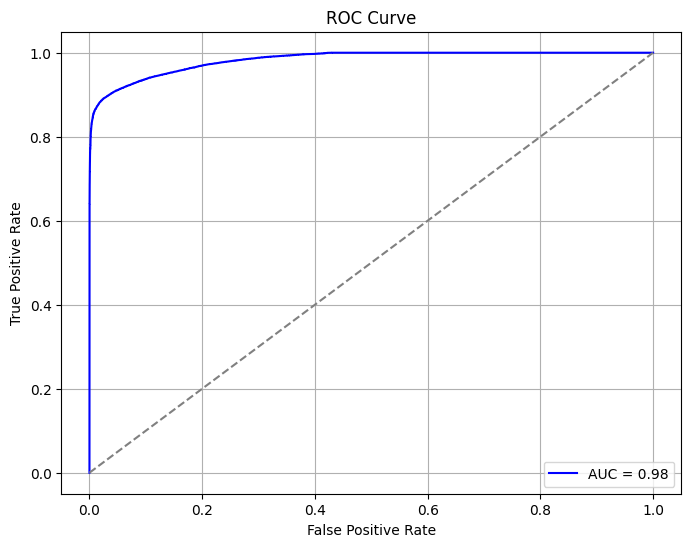

AUC: 0.9828


In [18]:
# Plot AUC-ROC
lgbm_auc = plot_auc_roc(y_test, y_proba)
print(f"AUC: {lgbm_auc:.4f}")

In [19]:
# Save the tuned LightGBM model
joblib.dump(lgbm_grid_search, "../models/lgbm_gs_model.joblib")

['../models/lgbm_gs_model.joblib']

## CatBoost

In [9]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    """
    Objective function for Optuna to optimize CatBoost hyperparameters.
    """
    params = {
        "iterations": trial.suggest_int("iterations", 500, 2000, step=500),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
        "task_type": "GPU",  # Ensure GPU usage
        "devices": "0",
    }

    # Handle bootstrap_type-specific parameters correctly
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 1)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1)

    # Train the model with cross-validation
    catboost_model = CatBoostClassifier(**params, verbose=0)
    accuracy = cross_val_score(catboost_model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=1).mean()

    return accuracy

In [10]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Print best parameters
print("Best Optuna Parameters:", study.best_params)
print("Best Optuna Score:", study.best_value)

[I 2025-02-05 21:34:59,032] A new study created in memory with name: no-name-bf4d858b-113a-4ed7-a66a-84d5d69ed884
[I 2025-02-05 21:35:51,293] Trial 0 finished with value: 0.9126215811411994 and parameters: {'iterations': 1000, 'depth': 10, 'learning_rate': 0.07670472828993721, 'l2_leaf_reg': 0.016914648678806064, 'border_count': 48, 'random_strength': 9.414795378255498, 'grow_policy': 'Lossguide', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8887012014672794}. Best is trial 0 with value: 0.9126215811411994.
[I 2025-02-05 21:36:59,663] Trial 1 finished with value: 0.9114923496012715 and parameters: {'iterations': 2000, 'depth': 8, 'learning_rate': 0.02267853589849503, 'l2_leaf_reg': 0.01778326151294763, 'border_count': 34, 'random_strength': 1.8683561002270213e-08, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9768725052057604}. Best is trial 0 with value: 0.9126215811411994.
[I 2025-02-05 21:37:50,552] Trial 2 finished with value: 0.91278125120

Best Optuna Parameters: {'iterations': 2000, 'depth': 3, 'learning_rate': 0.2935899202272831, 'l2_leaf_reg': 0.06272112203175657, 'border_count': 114, 'random_strength': 0.0017673835162720305, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5427675701753849}
Best Optuna Score: 0.9184559589237562


In [11]:
best_params = study.best_params
best_params["task_type"] = "GPU"
best_params["devices"] = "0"

catboost_optuna = CatBoostClassifier(**best_params)
catboost_optuna.fit(X_train, y_train)

0:	learn: 0.2555999	total: 4.94ms	remaining: 9.88s
1:	learn: 0.2012513	total: 9.11ms	remaining: 9.1s
2:	learn: 0.1819458	total: 13.3ms	remaining: 8.85s
3:	learn: 0.1640188	total: 17.4ms	remaining: 8.66s
4:	learn: 0.1524848	total: 21.6ms	remaining: 8.63s
5:	learn: 0.1462383	total: 25.7ms	remaining: 8.55s
6:	learn: 0.1408738	total: 29.8ms	remaining: 8.5s
7:	learn: 0.1346187	total: 34.1ms	remaining: 8.48s
8:	learn: 0.1317265	total: 37.4ms	remaining: 8.26s
9:	learn: 0.1291516	total: 41.4ms	remaining: 8.23s
10:	learn: 0.1266466	total: 45.5ms	remaining: 8.23s
11:	learn: 0.1254124	total: 49.7ms	remaining: 8.23s
12:	learn: 0.1225501	total: 54.1ms	remaining: 8.26s
13:	learn: 0.1216967	total: 58.2ms	remaining: 8.25s
14:	learn: 0.1212115	total: 62.2ms	remaining: 8.23s
15:	learn: 0.1203354	total: 66.4ms	remaining: 8.23s
16:	learn: 0.1190447	total: 72.2ms	remaining: 8.42s
17:	learn: 0.1184700	total: 77.9ms	remaining: 8.58s
18:	learn: 0.1181039	total: 82.4ms	remaining: 8.59s
19:	learn: 0.1173425	tot

In [12]:
catboost_optuna.score(X_test, y_test)

0.8694189379585094

In [13]:
# Predict labels and probabilities
y_pred = catboost_optuna.predict(X_test)
y_proba = catboost_optuna.predict_proba(X_test)[:, 1]

In [20]:
# Get evaluation metrics
catboost_metrics = evaluate_classification(y_test, y_pred, "CatBoost")
print("Evaluation Metrics:")
catboost_metrics

Evaluation Metrics:


{'Model Name': 'CatBoost',
 'Accuracy': 0.8694189379585094,
 'Precision': 0.8211280946455435,
 'Recall': 0.9752933909820877,
 'F1 Score': 0.8915956642298967}

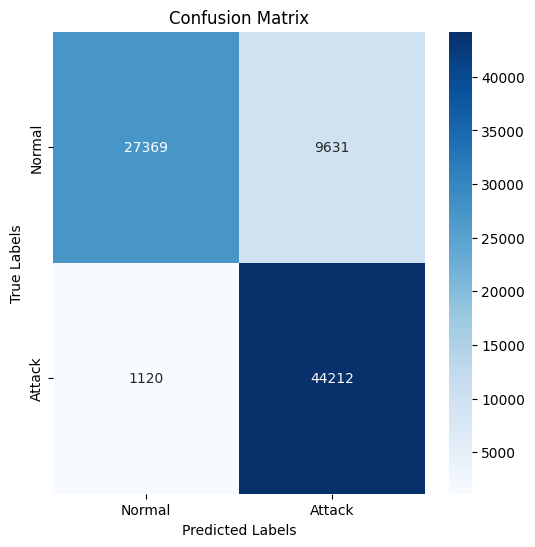

In [15]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names=["Normal", "Attack"])

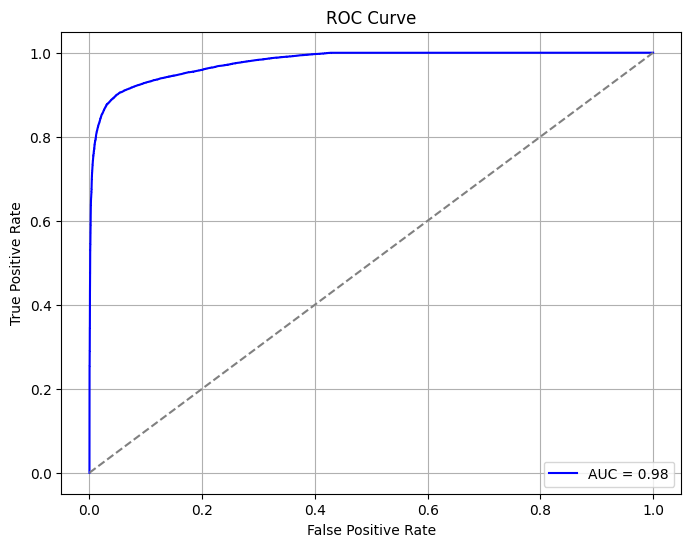

AUC: 0.9778


In [16]:
# Plot AUC-ROC
catboost_auc = plot_auc_roc(y_test, y_proba)
print(f"AUC: {catboost_auc:.4f}")

In [17]:
# Save the tuned CatBoost model
joblib.dump(catboost_optuna, "../models/catboost_rs_model.joblib")

['../models/catboost_rs_model.joblib']

**GridSearchCV with Optuna**

In [18]:
best_params

{'iterations': 2000,
 'depth': 3,
 'learning_rate': 0.2935899202272831,
 'l2_leaf_reg': 0.06272112203175657,
 'border_count': 114,
 'random_strength': 0.0017673835162720305,
 'grow_policy': 'Depthwise',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.5427675701753849,
 'task_type': 'GPU',
 'devices': '0'}

In [19]:
def objective(trial):
    """
    Fine-tune the best Optuna parameters using a smaller search space (GridSearch-like).
    """
    params = {
        "iterations": trial.suggest_categorical("iterations", [1500, 2000, 2500]),
        "depth": trial.suggest_int("depth", max(2, best_params["depth"] - 1), min(10, best_params["depth"] + 1)),
        "learning_rate": trial.suggest_float("learning_rate", best_params["learning_rate"] * 0.8, best_params["learning_rate"] * 1.2, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", best_params["l2_leaf_reg"] * 0.5, best_params["l2_leaf_reg"] * 1.5, log=True),
        "border_count": trial.suggest_int("border_count", best_params["border_count"] - 10, best_params["border_count"] + 10),
        "random_strength": trial.suggest_float("random_strength", best_params["random_strength"] * 0.5, best_params["random_strength"] * 1.5, log=True),
        "grow_policy": best_params["grow_policy"],
        "bootstrap_type": best_params["bootstrap_type"],
        "subsample": trial.suggest_float("subsample", best_params["subsample"] * 0.9, best_params["subsample"] * 1.1),
        "task_type": "GPU",
        "devices": "0",
    }

    # Train the model with cross-validation
    catboost_model = CatBoostClassifier(**params, verbose=0)
    accuracy = cross_val_score(catboost_model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=1).mean()

    return accuracy

In [21]:
# Create and run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Print final best parameters
print("Best Optuna GridSearch Parameters:", study.best_params)
print("Best Optuna GridSearch Score:", study.best_value)

[I 2025-02-05 22:58:43,416] A new study created in memory with name: no-name-d716bb40-dd9b-45d6-91f9-0c0038332587
Best trial: 0. Best value: 0.913431:   3%|████▎                                                                                                                              | 1/30 [00:57<27:47, 57.51s/it]

[I 2025-02-05 22:59:40,939] Trial 0 finished with value: 0.9134314413212585 and parameters: {'iterations': 2500, 'depth': 3, 'learning_rate': 0.3179548114686934, 'l2_leaf_reg': 0.03559371533372053, 'border_count': 117, 'random_strength': 0.0009018184054188168, 'subsample': 0.5717885167899528}. Best is trial 0 with value: 0.9134314413212585.


Best trial: 1. Best value: 0.915376:   7%|████████▋                                                                                                                          | 2/30 [01:39<22:29, 48.20s/it]

[I 2025-02-05 23:00:22,613] Trial 1 finished with value: 0.9153762203088924 and parameters: {'iterations': 2000, 'depth': 2, 'learning_rate': 0.23814699562847863, 'l2_leaf_reg': 0.0688379422155211, 'border_count': 116, 'random_strength': 0.0019139157936799711, 'subsample': 0.5096798691781587}. Best is trial 1 with value: 0.9153762203088924.


Best trial: 1. Best value: 0.915376:  10%|█████████████                                                                                                                      | 3/30 [02:09<18:05, 40.19s/it]

[I 2025-02-05 23:00:53,267] Trial 2 finished with value: 0.9129979869925029 and parameters: {'iterations': 1500, 'depth': 2, 'learning_rate': 0.2925229559698777, 'l2_leaf_reg': 0.033505334526161515, 'border_count': 118, 'random_strength': 0.0012302390084431994, 'subsample': 0.5302429863490099}. Best is trial 1 with value: 0.9153762203088924.


Best trial: 1. Best value: 0.915376:  13%|█████████████████▍                                                                                                                 | 4/30 [02:56<18:29, 42.68s/it]

[I 2025-02-05 23:01:39,769] Trial 3 finished with value: 0.91404168687985 and parameters: {'iterations': 2000, 'depth': 3, 'learning_rate': 0.3352383905347422, 'l2_leaf_reg': 0.04821231166277832, 'border_count': 120, 'random_strength': 0.0024521356555372185, 'subsample': 0.5066347631654289}. Best is trial 1 with value: 0.9153762203088924.


Best trial: 1. Best value: 0.915376:  17%|█████████████████████▊                                                                                                             | 5/30 [04:05<21:48, 52.33s/it]

[I 2025-02-05 23:02:49,208] Trial 4 finished with value: 0.9149256929558574 and parameters: {'iterations': 2500, 'depth': 4, 'learning_rate': 0.24571343494683803, 'l2_leaf_reg': 0.059332450828855875, 'border_count': 104, 'random_strength': 0.0024385973300197236, 'subsample': 0.5076683570576592}. Best is trial 1 with value: 0.9153762203088924.


Best trial: 5. Best value: 0.917931:  20%|██████████████████████████▏                                                                                                        | 6/30 [04:53<20:18, 50.79s/it]

[I 2025-02-05 23:03:37,003] Trial 5 finished with value: 0.9179312650210031 and parameters: {'iterations': 2000, 'depth': 3, 'learning_rate': 0.25225488879179375, 'l2_leaf_reg': 0.04849335161254424, 'border_count': 119, 'random_strength': 0.0017929061721784134, 'subsample': 0.5898121039011193}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  23%|██████████████████████████████▌                                                                                                    | 7/30 [05:25<17:06, 44.61s/it]

[I 2025-02-05 23:04:08,895] Trial 6 finished with value: 0.9129580627671844 and parameters: {'iterations': 1500, 'depth': 2, 'learning_rate': 0.2772234420978598, 'l2_leaf_reg': 0.06957303086691943, 'border_count': 118, 'random_strength': 0.0018152967248768667, 'subsample': 0.593841890475563}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  27%|██████████████████████████████████▉                                                                                                | 8/30 [06:11<16:28, 44.92s/it]

[I 2025-02-05 23:04:54,481] Trial 7 finished with value: 0.9165225746373011 and parameters: {'iterations': 2000, 'depth': 3, 'learning_rate': 0.26950590045551465, 'l2_leaf_reg': 0.07798885021476294, 'border_count': 121, 'random_strength': 0.0009189059298756778, 'subsample': 0.5815900367971197}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  30%|███████████████████████████████████████▎                                                                                           | 9/30 [07:00<16:11, 46.27s/it]

[I 2025-02-05 23:05:43,710] Trial 8 finished with value: 0.9142526888842315 and parameters: {'iterations': 2500, 'depth': 2, 'learning_rate': 0.28922824888516463, 'l2_leaf_reg': 0.06582805273054985, 'border_count': 111, 'random_strength': 0.002076170435372983, 'subsample': 0.5331573456875863}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  33%|███████████████████████████████████████████▎                                                                                      | 10/30 [07:35<14:16, 42.82s/it]

[I 2025-02-05 23:06:18,824] Trial 9 finished with value: 0.9161518697144055 and parameters: {'iterations': 1500, 'depth': 3, 'learning_rate': 0.3018474303713844, 'l2_leaf_reg': 0.04253750920069024, 'border_count': 107, 'random_strength': 0.0013719345682233657, 'subsample': 0.5737168867662301}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  37%|███████████████████████████████████████████████▋                                                                                  | 11/30 [08:29<14:38, 46.24s/it]

[I 2025-02-05 23:07:12,798] Trial 10 finished with value: 0.9154902974231677 and parameters: {'iterations': 2000, 'depth': 4, 'learning_rate': 0.25899012410301103, 'l2_leaf_reg': 0.09181768974289745, 'border_count': 124, 'random_strength': 0.00157032727690184, 'subsample': 0.5532902209025419}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  40%|████████████████████████████████████████████████████                                                                              | 12/30 [09:17<14:02, 46.81s/it]

[I 2025-02-05 23:08:00,913] Trial 11 finished with value: 0.9153477208709531 and parameters: {'iterations': 2000, 'depth': 3, 'learning_rate': 0.2657138730904751, 'l2_leaf_reg': 0.09299529288814261, 'border_count': 124, 'random_strength': 0.0009136549100480333, 'subsample': 0.5969377921639029}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  43%|████████████████████████████████████████████████████████▎                                                                         | 13/30 [10:09<13:42, 48.39s/it]

[I 2025-02-05 23:08:52,928] Trial 12 finished with value: 0.9168761839306103 and parameters: {'iterations': 2000, 'depth': 4, 'learning_rate': 0.25605717730797295, 'l2_leaf_reg': 0.05031653706280521, 'border_count': 121, 'random_strength': 0.0011705755690594797, 'subsample': 0.5753125015579349}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  47%|████████████████████████████████████████████████████████████▋                                                                     | 14/30 [11:00<13:05, 49.07s/it]

[I 2025-02-05 23:09:43,570] Trial 13 finished with value: 0.9168419614468404 and parameters: {'iterations': 2000, 'depth': 4, 'learning_rate': 0.2520928779754138, 'l2_leaf_reg': 0.049586432355748715, 'border_count': 113, 'random_strength': 0.0011793629643704622, 'subsample': 0.557510348065075}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  50%|█████████████████████████████████████████████████████████████████                                                                 | 15/30 [11:54<12:40, 50.68s/it]

[I 2025-02-05 23:10:37,974] Trial 14 finished with value: 0.91520514675816 and parameters: {'iterations': 2000, 'depth': 4, 'learning_rate': 0.23658258162649295, 'l2_leaf_reg': 0.04427898805409076, 'border_count': 121, 'random_strength': 0.001606754086236826, 'subsample': 0.5607732875454751}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  53%|█████████████████████████████████████████████████████████████████████▎                                                            | 16/30 [12:48<12:02, 51.59s/it]

[I 2025-02-05 23:11:31,682] Trial 15 finished with value: 0.9154332783814032 and parameters: {'iterations': 2000, 'depth': 4, 'learning_rate': 0.25492537204129406, 'l2_leaf_reg': 0.03921815248283191, 'border_count': 114, 'random_strength': 0.0011001721403575478, 'subsample': 0.5829307229829838}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  57%|█████████████████████████████████████████████████████████████████████████▋                                                        | 17/30 [13:35<10:52, 50.20s/it]

[I 2025-02-05 23:12:18,646] Trial 16 finished with value: 0.9159123305423629 and parameters: {'iterations': 2000, 'depth': 3, 'learning_rate': 0.27184436806565393, 'l2_leaf_reg': 0.05746842162940361, 'border_count': 122, 'random_strength': 0.0013732120873352414, 'subsample': 0.539025690197167}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 18/30 [14:26<10:04, 50.40s/it]

[I 2025-02-05 23:13:09,534] Trial 17 finished with value: 0.917360955071698 and parameters: {'iterations': 2000, 'depth': 4, 'learning_rate': 0.2453566319596677, 'l2_leaf_reg': 0.05130931974348318, 'border_count': 111, 'random_strength': 0.0017669508072576424, 'subsample': 0.5845502430519918}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  63%|██████████████████████████████████████████████████████████████████████████████████▎                                               | 19/30 [15:00<08:20, 45.53s/it]

[I 2025-02-05 23:13:43,711] Trial 18 finished with value: 0.9150739584019997 and parameters: {'iterations': 1500, 'depth': 3, 'learning_rate': 0.24565022577617118, 'l2_leaf_reg': 0.05516171011841158, 'border_count': 110, 'random_strength': 0.002159829506643417, 'subsample': 0.4934678783860752}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  67%|██████████████████████████████████████████████████████████████████████████████████████▋                                           | 20/30 [16:09<08:47, 52.70s/it]

[I 2025-02-05 23:14:53,133] Trial 19 finished with value: 0.916562515775943 and parameters: {'iterations': 2500, 'depth': 4, 'learning_rate': 0.34755312449913195, 'l2_leaf_reg': 0.039073954829670535, 'border_count': 109, 'random_strength': 0.0017542234987338863, 'subsample': 0.5901378644290377}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 21/30 [16:57<07:40, 51.14s/it]

[I 2025-02-05 23:15:40,624] Trial 20 finished with value: 0.9157754529670186 and parameters: {'iterations': 2000, 'depth': 3, 'learning_rate': 0.28177234107385485, 'l2_leaf_reg': 0.044759894178391546, 'border_count': 114, 'random_strength': 0.002137032597669805, 'subsample': 0.5654054126554399}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 22/30 [17:49<06:52, 51.54s/it]

[I 2025-02-05 23:16:33,093] Trial 21 finished with value: 0.9146747485118087 and parameters: {'iterations': 2000, 'depth': 4, 'learning_rate': 0.26041127386088253, 'l2_leaf_reg': 0.04912674103857392, 'border_count': 119, 'random_strength': 0.0014011537742561744, 'subsample': 0.5811080530682039}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 23/30 [18:40<05:59, 51.38s/it]

[I 2025-02-05 23:17:24,091] Trial 22 finished with value: 0.9129181487874369 and parameters: {'iterations': 2000, 'depth': 4, 'learning_rate': 0.24708077487152033, 'l2_leaf_reg': 0.052276769821299085, 'border_count': 115, 'random_strength': 0.0016618140774682254, 'subsample': 0.5475444954321246}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 24/30 [19:33<05:10, 51.68s/it]

[I 2025-02-05 23:18:16,491] Trial 23 finished with value: 0.9140302757532321 and parameters: {'iterations': 2000, 'depth': 4, 'learning_rate': 0.2350960911345775, 'l2_leaf_reg': 0.058952830450838635, 'border_count': 112, 'random_strength': 0.0010245217588259951, 'subsample': 0.5715121027494853}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 25/30 [20:27<04:22, 52.55s/it]

[I 2025-02-05 23:19:11,049] Trial 24 finished with value: 0.91409872007026 and parameters: {'iterations': 2000, 'depth': 4, 'learning_rate': 0.2628040463597417, 'l2_leaf_reg': 0.06319746141483672, 'border_count': 122, 'random_strength': 0.0014673986371340677, 'subsample': 0.5862883646471467}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 26/30 [21:16<03:26, 51.53s/it]

[I 2025-02-05 23:20:00,215] Trial 25 finished with value: 0.9170700779456691 and parameters: {'iterations': 2000, 'depth': 3, 'learning_rate': 0.25106917434788906, 'l2_leaf_reg': 0.052308519451204925, 'border_count': 108, 'random_strength': 0.0019014765934129599, 'subsample': 0.5773420969242226}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 27/30 [22:03<02:30, 50.16s/it]

[I 2025-02-05 23:20:47,185] Trial 26 finished with value: 0.9153648243066888 and parameters: {'iterations': 2000, 'depth': 3, 'learning_rate': 0.24229008196363946, 'l2_leaf_reg': 0.046404270361929276, 'border_count': 107, 'random_strength': 0.0019506972712111843, 'subsample': 0.596214414068571}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 28/30 [22:50<01:37, 49.00s/it]

[I 2025-02-05 23:21:33,469] Trial 27 finished with value: 0.9172925065263392 and parameters: {'iterations': 2000, 'depth': 3, 'learning_rate': 0.25045913173727485, 'l2_leaf_reg': 0.03963869598611961, 'border_count': 108, 'random_strength': 0.0026432662436711627, 'subsample': 0.5669180646740598}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29/30 [23:50<00:52, 52.32s/it]

[I 2025-02-05 23:22:33,539] Trial 28 finished with value: 0.9150682576362199 and parameters: {'iterations': 2500, 'depth': 3, 'learning_rate': 0.2974809175620989, 'l2_leaf_reg': 0.031653964837280266, 'border_count': 106, 'random_strength': 0.002279937773523077, 'subsample': 0.5665085707992863}. Best is trial 5 with value: 0.9179312650210031.


Best trial: 5. Best value: 0.917931: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [24:21<00:00, 48.72s/it]

[I 2025-02-05 23:23:04,943] Trial 29 finished with value: 0.9130778333289744 and parameters: {'iterations': 1500, 'depth': 2, 'learning_rate': 0.31588433023821, 'l2_leaf_reg': 0.03761748093593539, 'border_count': 111, 'random_strength': 0.0023271748253766264, 'subsample': 0.5874760898635186}. Best is trial 5 with value: 0.9179312650210031.
Best Optuna GridSearch Parameters: {'iterations': 2000, 'depth': 3, 'learning_rate': 0.25225488879179375, 'l2_leaf_reg': 0.04849335161254424, 'border_count': 119, 'random_strength': 0.0017929061721784134, 'subsample': 0.5898121039011193}
Best Optuna GridSearch Score: 0.9179312650210031


In [34]:
study.best_params

{'iterations': 2000,
 'depth': 3,
 'learning_rate': 0.25225488879179375,
 'l2_leaf_reg': 0.04849335161254424,
 'border_count': 119,
 'random_strength': 0.0017929061721784134,
 'subsample': 0.5898121039011193}

In [35]:
best_params = study.best_params
best_params["task_type"] = "GPU"
best_params["devices"] = "0"
best_params["bootstrap_type"] = "Bernoulli"

# Remove "subsample" if "Bayesian" bootstrap is selected
if best_params["bootstrap_type"] == "Bayesian":
    best_params.pop("subsample", None)

catboost_optuna = CatBoostClassifier(**best_params)
catboost_optuna.fit(X_train, y_train)

0:	learn: 0.3664729	total: 6.01ms	remaining: 12s
1:	learn: 0.2729294	total: 11ms	remaining: 10.9s
2:	learn: 0.2301708	total: 16ms	remaining: 10.7s
3:	learn: 0.1933578	total: 20.9ms	remaining: 10.4s
4:	learn: 0.1769268	total: 25.7ms	remaining: 10.3s
5:	learn: 0.1609421	total: 30.5ms	remaining: 10.1s
6:	learn: 0.1565127	total: 34ms	remaining: 9.69s
7:	learn: 0.1536773	total: 37.6ms	remaining: 9.37s
8:	learn: 0.1461329	total: 41.2ms	remaining: 9.12s
9:	learn: 0.1434795	total: 44.3ms	remaining: 8.81s
10:	learn: 0.1417773	total: 48ms	remaining: 8.68s
11:	learn: 0.1402123	total: 51.6ms	remaining: 8.54s
12:	learn: 0.1382525	total: 55.1ms	remaining: 8.43s
13:	learn: 0.1371201	total: 59ms	remaining: 8.37s
14:	learn: 0.1363008	total: 64.3ms	remaining: 8.51s
15:	learn: 0.1350594	total: 69.6ms	remaining: 8.63s
16:	learn: 0.1328883	total: 74.5ms	remaining: 8.7s
17:	learn: 0.1306949	total: 77.2ms	remaining: 8.5s
18:	learn: 0.1285761	total: 80ms	remaining: 8.34s
19:	learn: 0.1276180	total: 82.9ms	rem

In [36]:
catboost_optuna.score(X_test, y_test)

0.8738036243501919

In [37]:
# Predict labels and probabilities
y_pred = catboost_optuna.predict(X_test)
y_proba = catboost_optuna.predict_proba(X_test)[:, 1]

In [38]:
# Get evaluation metrics
catboost_metrics = evaluate_classification(y_test, y_pred, "CatBoost")
print("Evaluation Metrics:")
catboost_metrics

Evaluation Metrics:


{'Model Name': 'CatBoost',
 'Accuracy': 0.8738036243501919,
 'Precision': 0.8230584319526627,
 'Recall': 0.9818891732109768,
 'F1 Score': 0.8954854544722971}

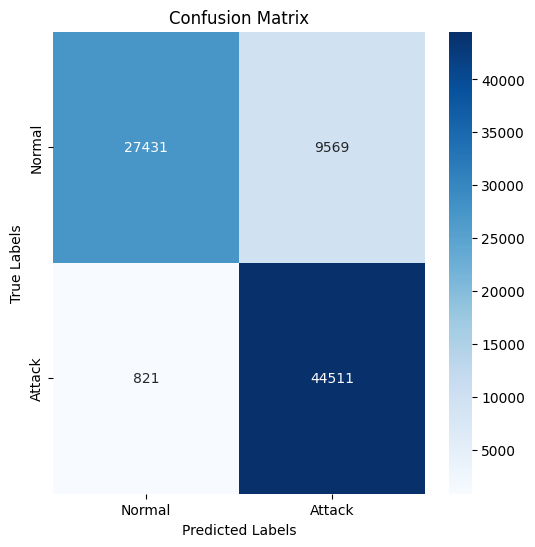

In [39]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names=["Normal", "Attack"])

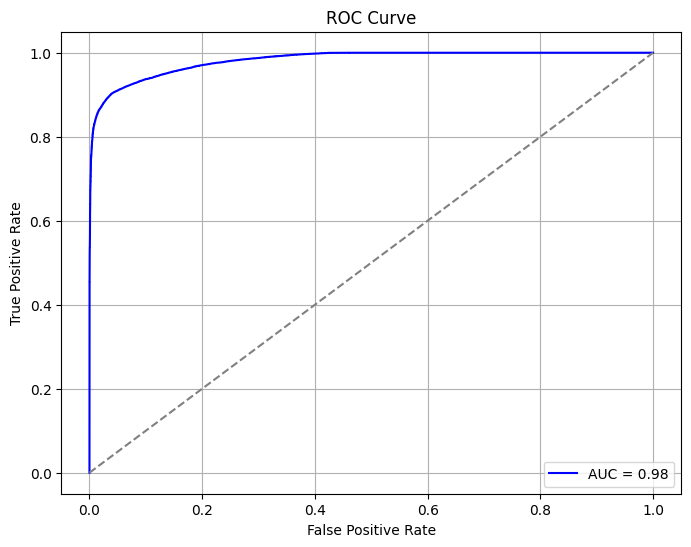

AUC: 0.9819


In [40]:
# Plot AUC-ROC
catboost_auc = plot_auc_roc(y_test, y_proba)
print(f"AUC: {catboost_auc:.4f}")

In [41]:
# Save the tuned CatBoost model
joblib.dump(catboost_optuna, "../models/catboost_gs_model.joblib")

['../models/catboost_gs_model.joblib']